In [1]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")
from sklearn.metrics import accuracy_score

import torch

In [2]:
# D: Hilfsfunktion um die vorhergesagten Wahrscheinlichkeiten in die Klassen umzuwandeln
# ---------
# E: Auxiliary function to convert the predicted probabilities into the classesdef convert_prob_into_class(probs):
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [3]:
# D: Hilfsfunktion um die Daten zu Visualisiern
# ---------
# E: Help function to visualize the data
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [4]:
# D: Größe des Datensatzes
# ---------
# E: Size of the dataset
N_SAMPLES = 1000
# D: Größe des Testsets
# ---------
# E: Size of the testset
TEST_SIZE = 0.1

## Hier werden die Daten von dem alten Modell erstellt. In der Wirklichkeit sehen wir das nicht.

In [5]:
# D: Generierung des Datansatzes 
# ---------
# E: generation of the data set 
X, y_true = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)

In [6]:
# Generierung der Daten durch ein anderes Modell
# ---------
# Generation of data by another model
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
model = torch.nn.Sequential(
            torch.nn.Linear(2, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 1),
            torch.nn.Sigmoid()
)
model.load_state_dict(torch.load('./old_model'))
xx = torch.from_numpy(X).to(device,torch.float32)
y_pred = model(xx).cpu().detach().numpy().squeeze()
y = convert_prob_into_class(y_pred)

In [7]:
# D: split in test und train set
# ---------
# E: split into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [8]:
# D: Check ob eine GPU da ist
# ---------
# E: Check if GPU is  available device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# D: Architektur des neuronalen Netzwerks
# wichtig ist, dass die aufeinander folgenden Layer die gleiche Größe haben
# ---------
# E: architecture of the neural network
# it is important that the successive layers have the same size
model_steal = torch.nn.Sequential(
            torch.nn.Linear(2, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 1),
            torch.nn.Sigmoid()
)
# D: Festlegen der Lossfunktion
# ---------
# E: Determine the loss function
loss_fn = torch.nn.BCELoss()

# D: Alles rüberschieben, sodass pytorch alles übernimmt
# Pytorch will Tensoren haben
# ---------
# E: Move everything over so that pytorch takes over everything
# Pytorch wants to have tensors
xx = torch.from_numpy(X_train).to(device,torch.float32)
yy = torch.from_numpy(y_train).to(device,torch.float32)
yy = yy.unsqueeze(-1)

# D: Festlegen der Lernrate 
# ---------
# E: Determine the learning rate 
learning_rate = 1e-4
# D: Festlegen des Optimierungsalgorithmus
# ---------
# E: Determine the optimization algorithm
optimizer = torch.optim.RMSprop(model_steal.parameters(), lr=learning_rate)
# D: Schleife über eine Anzahl von vorher festgelegten Epochen, um zu lernen
# ---------
# E: Loop over a number of pre-determined epochs to learn
for t in range(10000):
    # D: Vorwärtsdurchlauf
    # ---------
    # E: Forward pass
    y_pred = model_steal(xx)

    # D: Lossfunktion ausrechnen und anzeigen
    # ---------
    # E: Calculate and display loss function train set
    loss = loss_fn(y_pred, yy)
    if t % 100 == 99:
        print(t, loss.item())

    # D: Pytorch buffert den Gradienten aus allen vorigen Berechnungen
    # Um das los zu werden und nur den aktuellen zu haben
    # Nullen wir einmal den Gradienten
    # ---------
    # E: Pytorch buffers the gradient from all previous calculations.
    # To get rid of this and have only the current one
    # Let's zero the gradient once
    optimizer.zero_grad()

    # D: Rückwärtsdurchlauf
    # ---------
    # E: Backward pass
    loss.backward()

    # D: Update der Parameter
    # ---------
    # E: update parameter
    optimizer.step()

99 0.6351935267448425
199 0.5671341419219971
299 0.4964357912540436
399 0.4319782257080078
499 0.3784761428833008
599 0.33615872263908386
699 0.30206719040870667
799 0.273688942193985
899 0.24898923933506012
999 0.22637233138084412
1099 0.2051461935043335
1199 0.1849866360425949
1299 0.16606394946575165
1399 0.14827270805835724
1499 0.1315445601940155
1599 0.11612067371606827
1699 0.10247092694044113
1799 0.09034004807472229
1899 0.07969601452350616
1999 0.0705176368355751
2099 0.062491465359926224
2199 0.05569449067115784
2299 0.05001062527298927
2399 0.04505109041929245
2499 0.04057629778981209
2599 0.03640402853488922
2699 0.03285658359527588
2799 0.02956264838576317
2899 0.0267038457095623
2999 0.024226006120443344
3099 0.022105472162365913
3199 0.020275766029953957
3299 0.018588703125715256
3399 0.017260387539863586
3499 0.01614217832684517
3599 0.015159191563725471
3699 0.014275556430220604
3799 0.013490885496139526
3899 0.012787189334630966
3999 0.012149754911661148
4099 0.01158

In [9]:
# D: Hilfsvariablen für die Visualisierung
# ---------
# E: Auxiliary variables for visualization
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

# D: Erstellen eines Gitter für das Bild
# ---------
# E: Create a grid for the image
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [10]:
# D: Testset zu pytorch schrieben
# ---------
# E: convert test set to tensor for pytorch
xx_test = torch.from_numpy(X_test).to(device,torch.float32)
# D: Vorwärtsdurchlauf auf dem Testset
# ---------
# E: Forward pass on the test set
y_hat = model_steal(xx_test).cpu().detach().numpy()
# D: Umwandeln in Klassen
# ---------
# E: Convert to classes
y_pred = convert_prob_into_class(y_hat)
acc_test = (y_test.reshape(int(N_SAMPLES*TEST_SIZE),1) == y_pred).all(axis=1).mean()
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.99


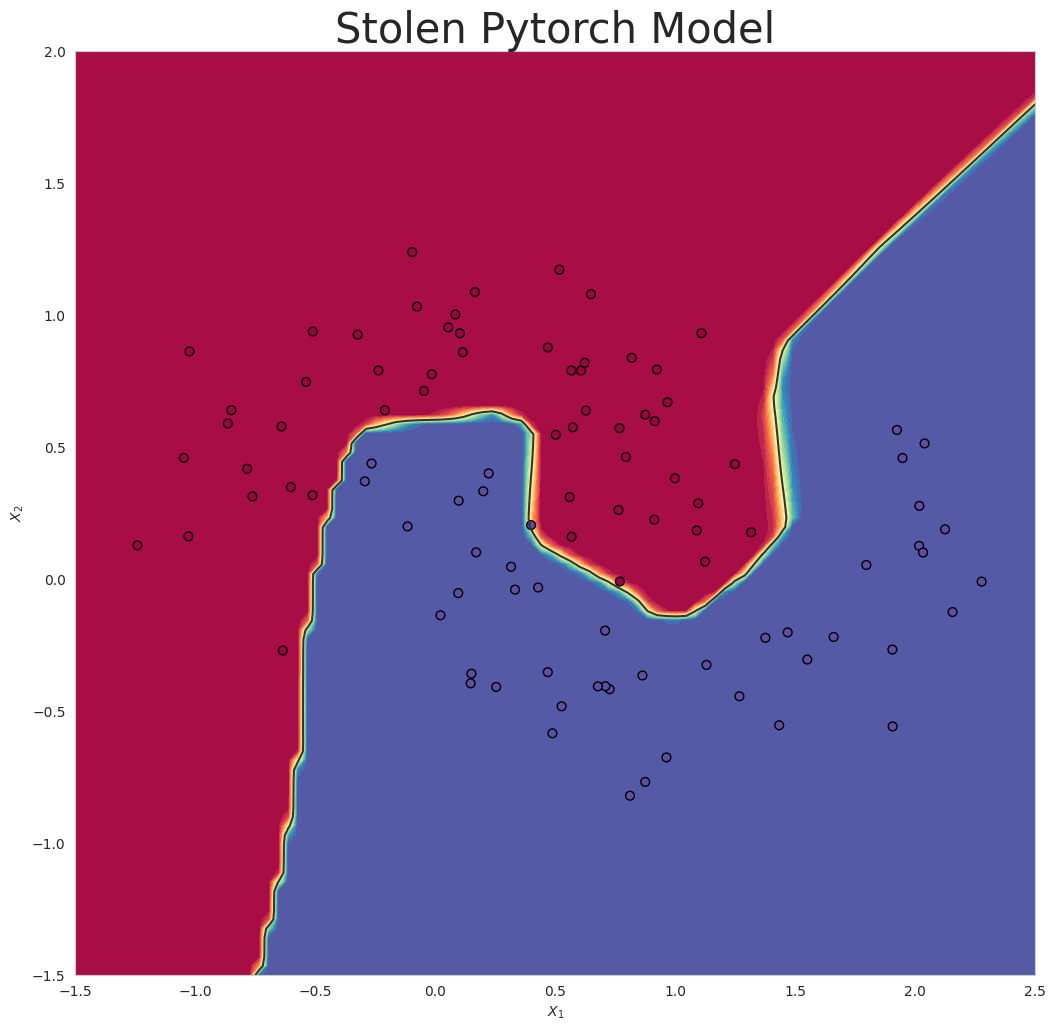

In [11]:
# D: Visualisierung der gelernten Gewichte und dem Test set
# ---------
# E: Visualization of the learned weights and the test set
xx = torch.from_numpy(grid_2d).to(device,torch.float32)
y_plot = y_hat = model_steal(xx).cpu().detach().numpy()
make_plot(X_test, y_test, "Stolen Pytorch Model", file_name=None, XX=XX, YY=YY, preds=y_plot)